# Road Network Analysis And Optimization

### **Road Optimization Study for Gazi Street in Elazığ City Center**

Gazi Street, located in the city center of Elazığ, is a critical area for transportation due to its heavy traffic flow and the lack of alternative routes. In this study, without using current traffic data, the goal is to reduce the traffic load on Gazi Street by adding new alternative roads. The open spaces, existing roads, and connection points in the area will be analyzed to determine the most suitable routes that can be integrated into the main arteries. By adding new roads, the aim is to create a more balanced traffic flow, reduce travel times, and make urban transportation more efficient. In this context, alternative routes will be planned to determine where they can be added, which points will be connected, and how traffic congestion can be distributed, ultimately creating a sustainable road optimization for the Gazi Street area.


## Required Libraries Installation 

In [3]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install osmnx

Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install networkx

Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [13]:
pip install python-louvain

Note: you may need to restart the kernel to use updated packages.


In [24]:
pip install folium

Note: you may need to restart the kernel to use updated packages.


In [209]:
pip install scipy


Note: you may need to restart the kernel to use updated packages.


## Importing Libraries Into The Project

In [247]:
import osmnx as ox
import networkx as nx
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from community import community_louvain
import folium
from folium.plugins import MarkerCluster
from folium.plugins import Fullscreen
from folium.plugins import MiniMap ,MousePosition
import plotly.graph_objects as go
from scipy.stats import entropy

## Fetching City Road Networks

In [191]:
# The coordinates of Elazığ (Gazi Street)
gazi_lat, gazi_lon = 38.6754194, 39.2153528

# Creating the road network graph for Gazi Street
G = ox.graph_from_point((gazi_lat, gazi_lon), dist=1500, dist_type = 'network' , network_type="drive" , retain_all = False , truncate_by_edge = False)
#osmnx.graph.graph_from_point(center_point, dist, *, dist_type='bbox' 'network', network_type={“all”, “all_public”, “bike”, “drive”, “drive_service”, “walk”} , simplify=True, retain_all=False, truncate_by_edge=False, custom_filter=None)

#Get the nodes
gazi_nodes = list(G.nodes())

# Get the edges
gazi_edges = list(G.edges())

print("The road network for Gazi Street has been created.")
print(f"Total number of nodes: {len(gazi_nodes)}")
print(f"Total number of edges: {len(gazi_edges)}")
print(f"Graph type: {type(G)}")


#print("\n Gazi Street Node Lists:")
#print ("gazi_nodes")

#print("\n Gazi Street  Edge Lists:")
#print ("gazi_edges")


The road network for Gazi Street has been created.
Total number of nodes: 955
Total number of edges: 2645
Graph type: <class 'networkx.classes.multidigraph.MultiDiGraph'>


- **955 Nodes:** These are intersections, road points, or connection points in the road network.
- **2645 Edges:** These are the road connections between nodes. Each edge represents a road segment.
- **MultiDiGraph:** A multi-directional, directed graph structure. The same two nodes can have multiple roads between them, meaning the roads can be bidirectional.


## Graph Visualization Of City Road Networks

In [293]:
# Creating map
m = folium.Map(location=[agri_lat, agri_lon], zoom_start=13)

# TileLayer
folium.TileLayer(
    tiles='https://tiles.stadiamaps.com/tiles/alidade_satellite/{z}/{x}/{y}{r}.{ext}',
    attr='Stadia Maps',
    name='Satellite',
    ext='png'
).add_to(m)

#Group the nodes using MarkerCluster
marker_cluster = MarkerCluster().add_to(m)

#Add the nodes to the map
for node, data in G.nodes(data=True):
    folium.Marker(
        location=[data['y'], data['x']],
        popup=f"Node: {node}",
        icon=folium.Icon(color="blue", icon="flag")
    ).add_to(marker_cluster)

#Extract the road geometries (edges) nx -> geodataframe
edges_gdf = ox.graph_to_gdfs(G, nodes=False, edges=True)

#Add the roads to the map
for _, row in edges_gdf.iterrows():
  
    line = row['geometry']
    
    
    road_length = row['length']
    
   
    road_type = row.get('highway', 'Unknown')
    
   
    if isinstance(road_type, list):
        road_type = ', '.join(road_type)
    
   
    lat_lon_u = (line.coords[0][1], line.coords[0][0])  # Start point
    lat_lon_v = (line.coords[-1][1], line.coords[-1][0])  # End point
    
   
    popup_content = f"""
    <strong>Road Information</strong><br>
    <b>Connection Points:</b><br>
    Point ({lat_lon_u}) - Point ({lat_lon_v})<br><br>
    <b>Road Length:</b> {road_length:.2f} m<br>
    <b>Road Type:</b> {road_type.capitalize()}<br>
    """
    
    # Add the road geometry to the map
    folium.PolyLine(
        locations=[(lat, lon) for lon, lat in line.coords],
        color="red", 
        weight=4,     
        opacity=0.7
    ).add_to(m).add_child(folium.Popup(popup_content, max_width=300))

folium.plugins.Fullscreen(
    position="topright",
    title="Expand me",
    title_cancel="Exit me",
    force_separate_button=True,
).add_to(m)

folium.plugins.MiniMap(toggle_display=True).add_to(m)



formatter = "function(num) { return num.toFixed(6); }" 
folium.plugins.MousePosition(
    position="topright",
    separator=" | ",
    empty_string="NaN",
    lng_first=True,
    num_digits=6,  # 6 haneli hassasiyet
    prefix="Coordinates: ",
    lat_formatter=formatter,
    lng_formatter=formatter
).add_to(m)


layer_right = folium.TileLayer('Stamen Terrain')
layer_left = folium.TileLayer('OpenStreetMap')
sbs = folium.plugins.SideBySideLayers(layer_left=layer_left, layer_right=layer_right)
layer_left.add_to(m)
layer_right.add_to(m)
sbs.add_to(m)


m


# Degree Centrality 


Degree Centrality is a simple and widely used network centrality measure that quantifies the number of connections a node has to other nodes in a network. This measure helps determine how central a node is in the network and how many connections it has to other nodes.

#### How is Degree Centrality Calculated?

- **In Undirected Networks**: The degree centrality of a node is determined by the number of edges connected to that node.

  $$
  C_D(v) = \frac{\text{Number of connections (degree)}}{\text{Total number of nodes} - 1}
  $$

  Where:
  - $C_D(v)$ is the degree centrality of node $v$,
  - The number of connections is the number of edges connected to the node,
  - The total number of nodes is the total number of nodes in the network.

- **In Directed Networks**: Degree centrality can be calculated separately for incoming connections (in-degree) and outgoing connections (out-degree).

  - For incoming connections:

  $$
  C_D(v)_{\text{in}} = \frac{\text{Number of incoming edges}}{\text{Total number of nodes} - 1}
  $$

  - For outgoing connections:

  $$
  C_D(v)_{\text{out}} = \frac{\text{Number of outgoing edges}}{\text{Total number of nodes} - 1}
  $$

#### Meaning of Degree Centrality

- **High Degree Centrality**: A node with more connections in the network is considered more central. This means it has more influence or control within the network.

- **Low Degree Centrality**: A node with fewer connections in the network is more isolated, and its influence in the network is limited.


In [320]:
# Calculate degree centrality
degree_centrality = nx.degree_centrality(G)


#print("Degree Centrality for each node:")
#for node, centrality in degree_centrality.items():
    #print(f"Node {node}: {centrality}")


In [322]:
# Sort the nodes in descending order according to degree centrality
sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

#print("Degree Centrality for each node (sorted):")
#for node, centrality in sorted_degree_centrality:
    #print(f"Node {node}: {centrality}")

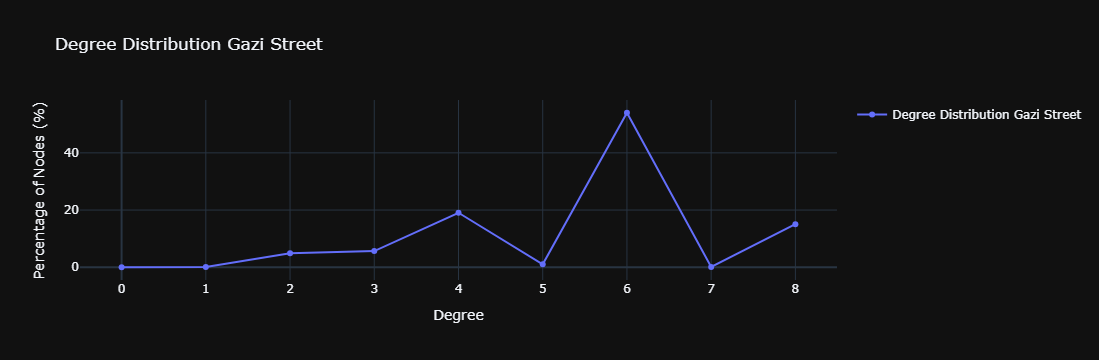

   Degree  Percentage of Nodes
0       0             0.000000
1       1             0.104712
2       2             4.921466
3       3             5.654450
4       4            19.057592
5       5             1.047120
6       6            54.031414
7       7             0.104712
8       8            15.078534


In [ ]:
# Calculates the number of nodes for each degree in the network.
degree = nx.degree_histogram(G)

# Calculates the percentage of nodes for each degree in the network.
perc_degree = [((d * 100) / G.number_of_nodes()) for d in degree]

# Creates the range of degree values.
deg_domain = list(range(0, len(degree)))

# Creates the Plotly figure.
fig = go.Figure()

# Adds the data to the figure.
fig.add_trace(go.Scatter(
    x=deg_domain, 
    y=perc_degree,
    mode='lines+markers',
    name=f'Degree Distribution Gazi Street',
    line=dict(width=2),  
    marker=dict(size=6)  
))

# Sets the layout of the plot.
fig.update_layout(
    title=f"Degree Distribution Gazi Street",
    xaxis_title="Degree",
    yaxis_title="Percentage of Nodes (%)",
    showlegend=True,
    template="plotly_dark", 
    hovermode='closest'
)

# Displays the plot.
fig.show()

# Creates a DataFrame with degree and percentage of nodes data.
degree_data = {
    "Degree" : deg_domain , 
    "Percentage of Nodes" : perc_degree
}

# Converts the data into a pandas DataFrame.
df = pd.DataFrame(degree_data)

# Prints the DataFrame.
print(df)


### Degree Centrality Entropy

In general, entropy measures the uncertainty or disorder in a system. In the context of network analysis, entropy helps us understand the diversity and disorder in the distribution of connections in a network. High entropy typically indicates that the centrality of nodes is unevenly distributed in the network. In this case, some nodes may be more central, while others may be more isolated. On the other hand, low entropy indicates that the degree distribution in the network is more homogeneous. In such a network, all nodes may have similar degrees, and there is no distinct centralization. In this type of network, the connection numbers of the nodes are close to each other, and the network exhibits a more ordered structure.

#### Entropy Calculation Formula:

Entropy is calculated using the following formula:

$$
H(X) = - \sum_{i=1}^{n} p_i \log(p_i)
$$

- $H(X)$: Entropy value
- $p_i$: The probabilities of each degree (i.e., the proportion of nodes with a certain degree in the network)
- $n$: Number of nodes or degree types

According to this formula, the more variety and disorder there is, the higher the entropy value will be.


In [367]:
total_nodes = G.number_of_nodes()

degree_probabilities = [count / total_nodes for count in degree]

entropy = -np.sum(np.array(degree_probabilities) * np.log2(np.array(degree_probabilities) + 1e-9))

print(f"Degree Distribution Entropy: {entropy}")


Degree Distribution Entropy: 1.8849799787985106


The entropy value I calculated for my network is 1.88498, which indicates that the degree distribution of my network has a high level of diversity and that there is noticeable disorder and inequality within the network. High entropy means that the number of connections between the nodes in the network varies significantly, meaning my network is disordered. This suggests that some nodes have many connections, while others have very few. This type of structure indicates the presence of central nodes in my network, but it also shows that many nodes are isolated. Since the diversity of connections is high, centralization in my network is not spread evenly and is more imbalanced. This suggests that my network has a complex structure with a significant inequality between the nodes.

## Connection Density

**Modularity** measures how separate the communities in a graph are from each other.

- **High modularity**: If the connections between cities (or any entities) are mostly within their own groups and there are very few connections to other groups, then the modularity is high. This means the cities form distinct groups and these groups are clearly separated.

- **Low modularity**: If cities frequently connect across groups and the groups are not very distinct, the modularity is low. This means the cities are closely connected and the groups are more mixed.


In [105]:
# Yönlü grafiği yönsüz grafiğe dönüştürülüyor
G_undirected = G.to_undirected()

# Louvain algoritması ile toplulukları tespit ediyoruz
partition = community_louvain.best_partition(G_undirected)

# Modülerlik değerini hesaplıyoruz
modularity = community_louvain.modularity(partition, G_undirected)

# Sonuçları yazdırıyoruz
print(f"Modularity for Ağrı: {modularity}")

Modularity for Ağrı: 0.8921005260332554


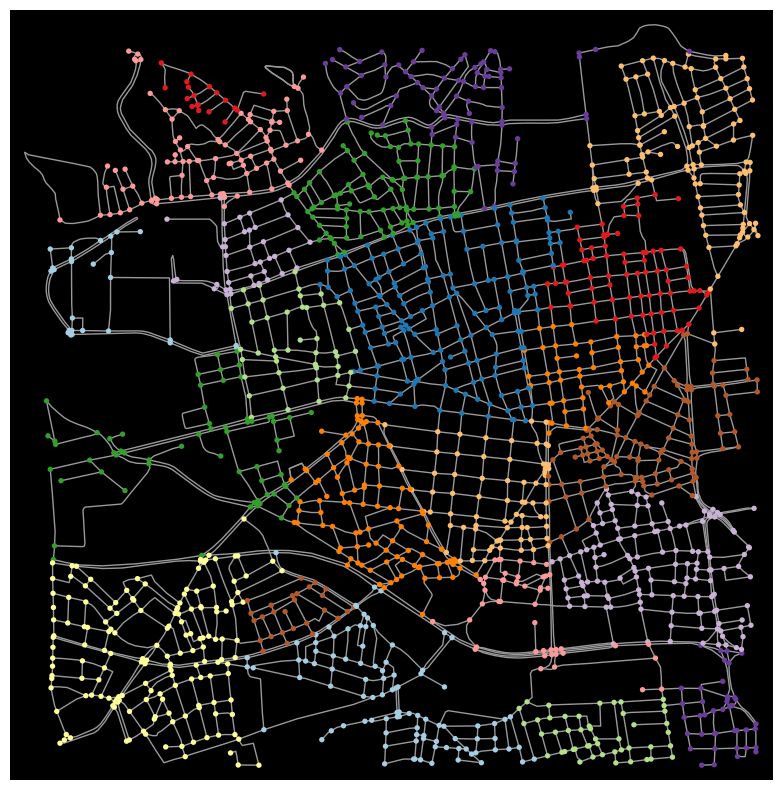

In [106]:
# Coloring for communities
nx.set_node_attributes(G_undirected, partition, name="attr_city")
nc = ox.plot.get_node_colors_by_attr(G_undirected, attr="attr_city", cmap='Paired')

fig, ax = ox.plot_graph(G_undirected, figsize=(10, 10), bgcolor="k", node_color=nc)
plt.pause(0.05)
plt.show()



## Closeness Centrality

Closeness centrality is a measure of how central a node is in a network. This measure is based on the average shortest path distance from a node to all other nodes in the network. In other words, it indicates how quickly and easily a node can reach other nodes in the network.

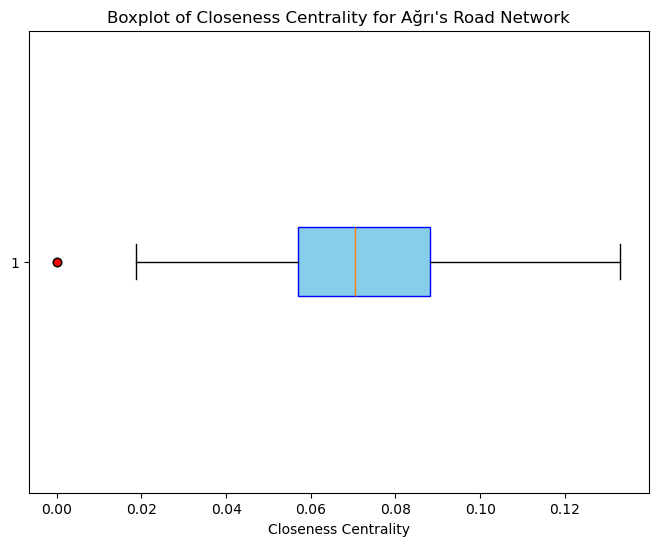

Closeness Centrality Statistics:
Min: 0.0000
1st Quartile: 0.0569
Median: 0.0703
3rd Quartile: 0.0882
Max: 0.1331
Mean: 0.0729


In [41]:

# Closeness centrality hesapla
closeness_values = list(nx.closeness_centrality(G).values())

# Boxplot çizme
plt.figure(figsize=(8,6))
plt.boxplot(closeness_values, vert=False, patch_artist=True, boxprops=dict(facecolor="skyblue", color="blue"), 
            flierprops=dict(markerfacecolor='red', marker='o', markersize=6, linestyle='none'))
plt.title("Boxplot of Closeness Centrality for Ağrı's Road Network")
plt.xlabel("Closeness Centrality")
plt.show()

# Metinsel çıktıyı oluşturma
closeness_stats = {
    'Min': np.min(closeness_values),
    '1st Quartile': np.percentile(closeness_values, 25),
    'Median': np.median(closeness_values),
    '3rd Quartile': np.percentile(closeness_values, 75),
    'Max': np.max(closeness_values),
    'Mean': np.mean(closeness_values),
}

print("Closeness Centrality Statistics:")
for stat, value in closeness_stats.items():
    print(f"{stat}: {value:.4f}")

NameError: name 'closeness_centralities' is not defined

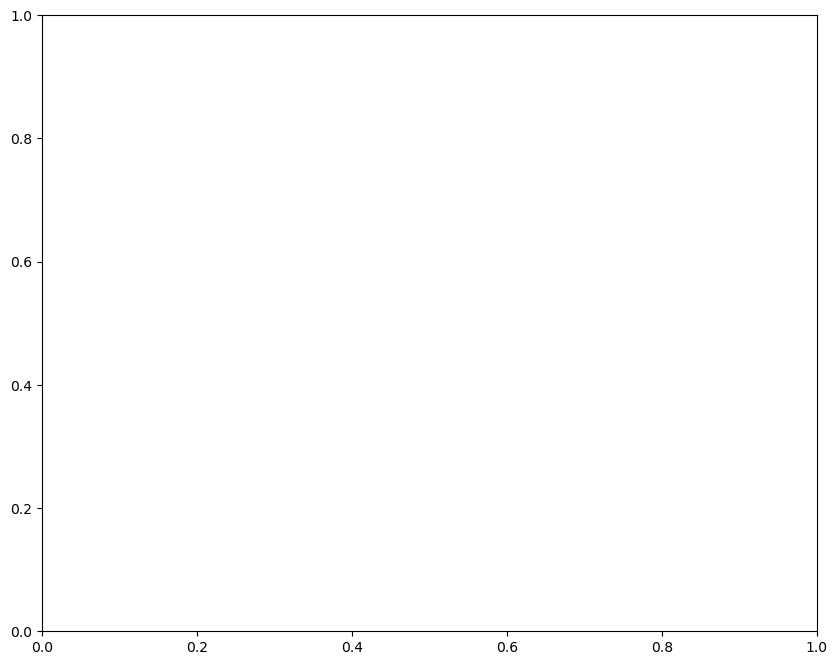

In [43]:


# Renk paleti (magma)
cmap = mpl.cm.magma

# Normalizasyon
norm = mpl.colors.Normalize(vmin=min(closeness_values), vmax=max(closeness_values))

# Harita çizimi
fig, ax = plt.subplots(figsize=(10, 8))

# Düğümleri closeness centrality değerlerine göre renklendir
node_colors = [closeness_centralities[node] for node in G.nodes()]
ox.plot_graph(G, ax=ax, node_color=node_colors, node_size=20, edge_color="gray", edge_linewidth=0.5, show=False)

# Renk barı ekleme
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Boş array, colorbar için gerekli
cbar = plt.colorbar(sm, ax=ax, orientation="horizontal", fraction=0.05, pad=0.02)
cbar.set_label("Closeness Centrality", fontsize=12)

# Başlık ekleme
plt.title(f"Closeness Centrality of Ağrı's Road Graph", fontsize=14)

# Haritayı göster
plt.show()


## Betweenness Centrality

Betweenness centrality measures how important a node is as an intermediary in a network. Nodes with high betweenness centrality values are those that lie on the shortest paths between other nodes. This indicates that they have the power to control the flow of information or resources in the network. Nodes with low betweenness centrality values play a less critical role in the network. In short, betweenness centrality identifies the important "bridge" points in a network.

Betweenness Centrality Statistics:
Min: 0.0000
1st Quartile: 0.0151
Median: 0.0949
3rd Quartile: 0.1261
Max: 0.3688
Mean: 0.0991


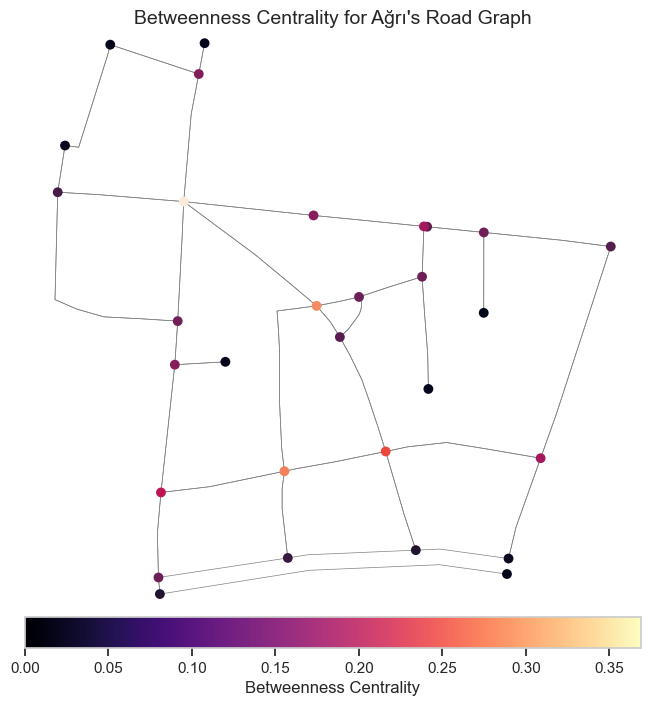

In [391]:

# Betweenness centrality hesaplama
betweenness_centrality = nx.betweenness_centrality(G)

# Betweenness centrality değerlerini elde et
betweenness_values = list(betweenness_centrality.values())

# İstatistiksel özet
betweenness_stats = {
    'Min': np.min(betweenness_values),
    '1st Quartile': np.percentile(betweenness_values, 25),
    'Median': np.median(betweenness_values),
    '3rd Quartile': np.percentile(betweenness_values, 75),
    'Max': np.max(betweenness_values),
    'Mean': np.mean(betweenness_values),
}

# Özet istatistikleri yazdırma
print("Betweenness Centrality Statistics:")
for stat, value in betweenness_stats.items():
    print(f"{stat}: {value:.4f}")
    

# Betweenness centrality değerlerine göre düğümlerin renklerini belirleyelim
node_colors = [betweenness_centrality[node] for node in G.nodes()]

# Grafik boyutu
fig, ax = plt.subplots(figsize=(10, 8))  # Manuel olarak ax oluşturduk

# Normalize edelim ve renk paleti (cmap) seçelim
norm = mpl.colors.Normalize(vmin=min(betweenness_values), vmax=max(betweenness_values))
cmap = mpl.cm.magma  # Renk paleti seçimi

# Ağın görselini çizme
ox.plot_graph(G, node_color=node_colors, node_size=50, edge_color="gray", edge_linewidth=0.5, ax=ax, show=False)

# Colorbar eklemek
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation="horizontal", fraction=0.05, pad=0.02)
cbar.set_label("Betweenness Centrality", fontsize=12)

# Başlık
plt.title("Betweenness Centrality for Ağrı's Road Graph", fontsize=14)

# Görseli göster
plt.show()

# Betweenness centrality değerlerini yazdırma
#for node, centrality in betweenness_centrality.items():
    #print(f"Node {node}: Betweenness Centrality = {centrality:.4f}")


## Eigenvector Centrality

It is a measure of how important a node is in a network. This measure looks at the quality of a node's connections. In other words, when determining a node's centrality, it doesn't only consider the number of nodes it is connected to, but also how central the nodes it is connected to are.

##  PageRank Centrality

PageRank Centrality is an algorithm used to evaluate the importance or relevance of nodes in a network. Each node is assigned a score based on the number and quality of links (or edges) pointing to it. In other words, PageRank measures how "important" a node is by considering not only the direct connections to that node but also the importance of the nodes that are providing the connections to it.